PDE:
\begin{equation}
u_{tt} = u_{xx}
\end{equation}
Initial conditions:
\begin{equation}
ic1 = u(x,0) = h(x) = sin(pi*k*x)) = sin(pi*2*x)
\\ic2 = u_t(x,0) = 0
\end{equation}
Boundary conditions:
\begin{equation}
bc1 = u(0,t) = h(0)
\\bc2 = u(L=1,t) = h(1)
\end{equation}

In [ ]:
!pip install tensorflow==2.10 keras==2.10 sciann
!pip install -q condacolab

In [2]:
import condacolab
condacolab.install()
!conda config --add channels conda-forge
!conda config --add channels nvidia
!conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
 - nvidia
Platform: linux-64
CondaError: KeyboardInterrupt



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sciann as sn
from sciann.utils.math import diff, sign, sin
from numpy import pi

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0] 



In [2]:
t = sn.Variable("t")
x = sn.Variable("x")
u = sn.Field("u")
u = sn.Functional(
    fields=[u],
    variables=[x, t],
    hidden_layers=4*[50],
    activation='sin'
)

In [10]:
u_tt = diff(u, t, order=2)
u_t = diff(u, t)
u_x = diff(u, x)
u_xx = diff(u, x, order=2)

# pde
pde = u_tt - u_xx

TOL = 1e-6
k = 2
L = 1
# initial conditions
ic1 = (1 - sign(t - TOL))*(u - sin(pi*k*x))
ic2 = (1 - sign(t - TOL))*(u_t - 0)
# boundary conditions
bc1 = (1 - sign(x - TOL))*(u - sin(pi*k*x))
bc2 = (1 - sign(L - x - TOL))*(u - 0)


In [11]:
# training domain
x_train, t_train = np.meshgrid(
    np.linspace(0, 1, 100),
    np.linspace(0, 3, 100)
)

In [14]:
m = sn.SciModel([t,x], [sn.PDE(pde),ic1,ic2,bc1,bc2], loss_func ='mse', optimizer='adam')
m.load_weights('trained-1d-wave-equation.hdf5')


Total samples: 10000 
Batch size: 1000 
Total batches: 10 


+ NTK evaluation time [s]: 5.9764182567596436 

+ adaptive_weights at epoch 1: [0.10018894660552385, 2.022559539932046, 0.15765784827693854, 1.4164280679075456, 1.3031655972779457]
Epoch 1/2000
10/10 [==============================] - 6s 46ms/step - batch: 4.5000 - size: 1000.0000 - loss: 0.0705 - sub_10_loss: 0.4809 - mul_8_loss: 4.0319e-05 - mul_9_loss: 4.0348e-04 - mul_11_loss: 5.6375e-05 - mul_12_loss: 0.0169 - lr: 0.0010 - time: 14.0722 - loss_weight_0: 0.1002 - loss_weight_1: 2.0226 - loss_weight_2: 0.1577 - loss_weight_3: 1.4164 - loss_weight_4: 1.3032 - loss_gradient_0: 675231.6848 - loss_gradient_1: 520.8247 - loss_gradient_2: 22972.7112 - loss_gradient_3: 821.1690 - loss_gradient_4: 1002.8726
Epoch 2/2000
10/10 [==============================] - 0s 37ms/step - batch: 4.5000 - size: 1000.0000 - loss: 0.0364 - sub_10_loss: 0.1626 - mul_8_loss: 1.1940e-04 - mul_9_loss: 0.0010 - mul_11_loss: 9.4900e-05 - mul_12_loss: 0

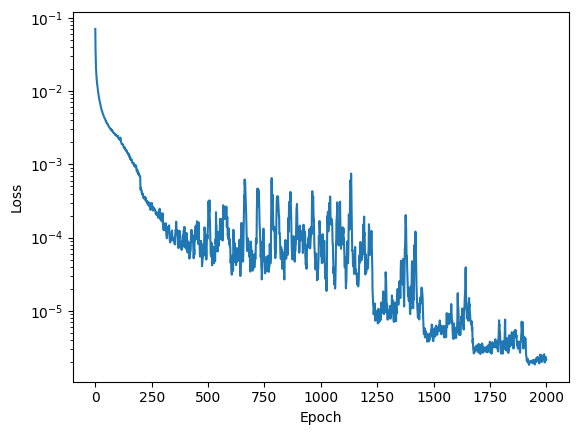

In [15]:
h = m.train(
    [t_train,x_train],
     5*['zeros'],
    epochs =2000,
    adaptive_weights =100,
    learning_rate =1e-3,
    batch_size = 1000,
    verbose =1)
plt.semilogy(h.history['loss']) # ve do thi Loss vs Epoch
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
# save weights
weights_trained = m.save_weights('trained-1d-wave-equation.hdf5')

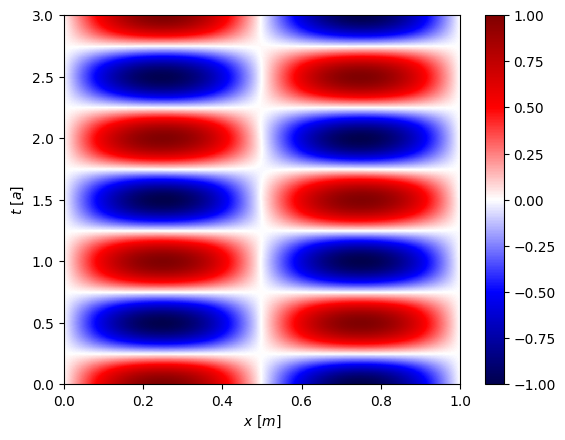

In [17]:
# predicting domain
x_pred, t_pred = np.meshgrid(
    np.linspace(0, 1, 1200),
    np.linspace(0, 3, 1000)
)
u_pred = u.eval([x_pred,t_pred])
fig = plt.figure()
plt.pcolor(x_pred, t_pred, u_pred, cmap='seismic')
plt.xlabel('$x~[m]$')
plt.ylabel('$t~[a]$')
plt.colorbar()

In [33]:
print(f't = {round(np.linspace(0, 1, 1000)[6]*10000)/10000}')

t = 0.006


In [7]:
x_pred, t_pred = np.meshgrid(
    np.linspace(0, 1, 1200),
    np.linspace(0, 3, 1000)
)
u_pred = u.eval([x_pred,t_pred])

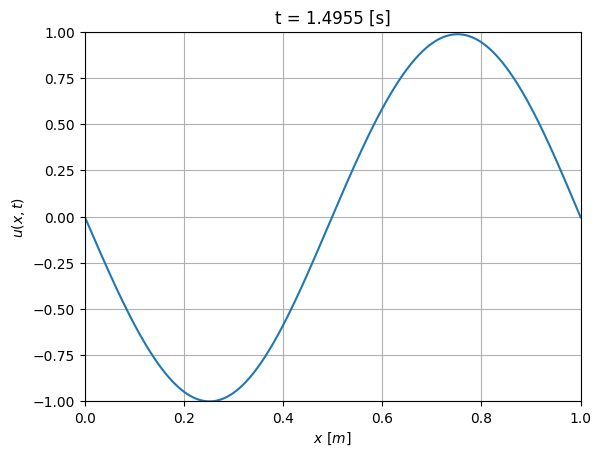

In [40]:
# save wave as .gif
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

fig, ax = plt.subplots()
# initial plot
line, = ax.plot(x_pred[0][:], u_pred[0][:])
ax.set(xlim=[0, 1], ylim=[-1, 1], xlabel='$x~[m]$', ylabel='$u(x,t)$')
ax.grid()

def update(frame):
    if np.mod(frame, 3) == 0:
      # for each frame, update the data stored on each artist.
      x = x_pred[frame][:]
      y = u_pred[frame][:]
      # update the line plot:
      line.set_xdata(x_pred[frame][:])
      line.set_ydata(u_pred[frame][:])
      ax.set_title(f't = {round(np.linspace(0, 3, 1000)[frame]*10000)/10000} [s]')
      return line


ani = animation.FuncAnimation(fig=fig, func=update, frames=500, interval=30)
ani.save('animation.gif', writer='pillow')
plt.show()